## Posterior Bayes Vulnerability

In [53]:
import collections
import math
import numpy as np
import pandas as pd
from sympy.utilities.iterables import partitions
from sympy.functions.combinatorial.numbers import stirling
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

### Variables To Test Functions

In [2]:
k = 3

In [3]:
n = 10

In [4]:
probs = [1/2, 1/3, 1/6]

In [5]:
uni_probs = [1/3, 1/3, 1/3]

In [6]:
range_max = 200

### Functions

__uni_post_bayes_vuln__ calculates the posterior Bayes vulnerability under a *uniform* prior using Stirling numbers of the second kind. <br>
n: size of the column <br>
k: number of unique plaintext values/diseases <br>
$$V_1[\pi \triangleright C] = \frac{\sum_{i=1}^{min(n,k)} s2(n, i)}{k^n} $$

In [2]:
def uni_post_bayes_vuln(n, k):
    num = 0
    den = 0
    for i in range(1, k+1): # goes from 1-k
        num = num + stirling(n, i)
    den = pow(k, n)
    return num/den

In [8]:
uni_post_bayes_vuln(3, k)

5/27

__prior_bayes_vuln__ calculates the prior Bayes vulnerability <br>
n: the size of the column <br>
Pi: the probability distribution of individual diseases <br>
In this case, the adversary would choose the most likely disease for every column.<br>
Therefore, the prior Bayes vulnerability is $(\max\pi)^n$

In [3]:
def prior_bayes_vuln(n, Pi):
    Pi.sort(reverse=True) 
    return pow(Pi[0],n)

__calc_set_partitions(n,p)__ calculates the number of set partitions
<br>
n: positive integer
<br>
p: a unique integer partition, as a python dictionary
<br>
Example:
```python
calc_set_partitions(6, {4:1, 1:2})
```
Output:
```python
15.0
```
Specific formula:<br>
$$\text{set partitions}(6,\{4:1, 1:2\}) = \frac{6!}{\left(4!\right)1! \times \left(1!1!\right)2!} $$

Generalized formula:<br>
With an interger partition $p$ containing integers $i$, each with multiplicity of $m$,
$$\text{set partitions}(n,p)=\frac{n!}{\prod_{i \in p} i!^m m!}$$

In [4]:
def calc_set_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    num_index = num / den
    return num_index

In [59]:
calc_set_partitions(4, {2:1, 1:2})

6.0

__calc_max_prob__ calculates the maximum probability of a unique integer partition <br>
Multiplies the largest fraction in $\pi$ to the power of the largest integer in the integer partition in decending order<br>
p: a unique integer partition, as a python dictionary<br>
Pi: the prior probability distribution<br>
Example:
```python
calc_max_prob({4:1,1:2},[1/2, 1/3, 1/6])
```
Output:
```python
0.003472222222222222
``` 
which is equal to 1/288

In [5]:
def calc_max_prob(p, Pi):
    Pi.sort(reverse=True)
    frac = 1
    ind = 0
    val = -1
    for key in sorted(p.keys(), reverse=True):
        val = p[key]
        for i in range(val):
            frac = frac * pow(Pi[ind], key)
            ind = ind + 1
    return frac

$$ V_1 [C \triangleright \pi ]  = \sum_{p=1}^{|\text{partitions}(n, k)|} \text{set partitions}(n, p)\times\text{max prob} (p, \pi )  $$

__partitions(n, m)__ generates a dictionary of integer partitions
<br>
n: positive integer
<br>
m: the maximum number of parts in partition
<br>
Outputs a dictionary where the keys are the integers and the values are the number of times that integer occurs

Example:
```python
for p in partitions(6,3):
    print(p)
```
Output:
```python
{6:1}
{5:1, 1:1}
{4:1, 2:1}
{4:1, 1:2}
{3:2}
{3:1, 2:1, 1:1}
{2:3}
```
For every dictionary, __nonuni_post_bayes_vuln__ multiplies the number of set partitions and its max probability.
These numbers are added together for all integer partitions to calculate the final posterior bayes vulnerability.

In [6]:
def nonuni_post_bayes_vuln(n, k, Pi):
    pbvsum = 0
    for p in partitions(n, m=k):  
        num = calc_set_partitions(n,p)
        frac = calc_max_prob(p, Pi)
        val = num * frac
        pbvsum = pbvsum + val
    return pbvsum

In [60]:
Pi = [1/3, 1/3, 1/3]
n = 4
k = 3
pbvsum = 0
for p in partitions(n, m=k):
    print("P: ", p)
    num = calc_set_partitions(n,p)
    print("num of index partitions: ", num)
    frac = calc_max_prob(p, Pi)
    print("best you can do: ", frac)
    val = num * frac
    print("weigh by num of index partitions: ", val)
    pbvsum = pbvsum + val
print(pbvsum)

P:  {4: 1}
num of index partitions:  1.0
best you can do:  0.012345679012345677
weigh by num of index partitions:  0.012345679012345677
P:  {3: 1, 1: 1}
num of index partitions:  4.0
best you can do:  0.012345679012345675
weigh by num of index partitions:  0.0493827160493827
P:  {2: 2}
num of index partitions:  3.0
best you can do:  0.012345679012345678
weigh by num of index partitions:  0.037037037037037035
P:  {2: 1, 1: 2}
num of index partitions:  6.0
best you can do:  0.012345679012345678
weigh by num of index partitions:  0.07407407407407407
0.1728395061728395


#### Test Calculations

In [13]:
prior_bayes_vuln(6, probs)

0.015625

In [10]:
nonuni_post_bayes_vuln(10, 3, probs)

0.5100027327674895

In [15]:
745/1728

0.43113425925925924

### Functions to graph different priors, k, and n-ranges

***Manually write correct graph heading***

In [50]:
def graph_it_bayes(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    y_posterior = df["posterior"].iloc[-1] # saves last posterior y
    y_prior = df["prior"].iloc[-1] # save last prior y for annotation
    
    plt.plot(x, 'prior', 
             data=df,
             label="prior")
    plt.plot(x, 'posterior',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="posterior")
    plt.xlabel('n values')
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    # green dot for last y posterior vulnerability
    plt.annotate('%.4f' % y_posterior,
                 xy=[n_range, y_posterior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_posterior, 
             marker = 'o', 
             markerfacecolor='green',
             markeredgecolor='green')
    
    # green dot for last y prior vulnerability
    plt.annotate('%.4f' % y_prior,
                 xy=[n_range, y_prior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_prior, 
             marker = 'o', 
             markerfacecolor='blue',
             markeredgecolor='blue')
    
    # title rounds the prior
    format_probs = ['%.2f' % prob for prob in probs]
    plt.title(r'Bayes vulnerability under $\delta = \left(\frac{1}{2}, \frac{26}{100}, \frac{24}{100}\right)$', fontsize = 16, y=1.02)
    plt.legend(loc='upper left')
    # legend adjusted so it doesn't run into annotations
    #plt.legend(loc='center left', 
     #         bbox_to_anchor= (1.01, .5),
      #        frameon=False)
    plt.show()
    plt.close()

In [23]:
def graph_it_bayes_4(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    y_posterior = df["posterior"].iloc[-1] # saves last posterior y
    y_prior = df["prior"].iloc[-1] # save last prior y for annotation
    
    plt.plot(x, 'prior', 
             data=df,
             label="prior")
    plt.plot(x, 'posterior',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="posterior")
    plt.xlabel('n values')
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    # green dot for last y posterior vulnerability
    plt.annotate('%.4f' % y_posterior,
                 xy=[n_range, y_posterior],
                 xytext=(-20, 15),
                 textcoords='offset points')
    plt.plot(n_range, y_posterior, 
             marker = 'o', 
             markerfacecolor='green',
             markeredgecolor='green')
    
    # green dot for last y prior vulnerability
    plt.annotate('%.4f' % y_prior,
                 xy=[n_range, y_prior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_prior, 
             marker = 'o', 
             markerfacecolor='blue',
             markeredgecolor='blue')
    
    # title rounds the prior
    format_probs = ['%.2f' % prob for prob in probs]
    plt.title(f'Prior and Posterior Bayes Vulnerability, k = {k}')
    plt.legend(loc='upper left')
    # legend adjusted so it doesn't run into annotations
    #plt.legend(loc='center left', 
     #         bbox_to_anchor= (1.01, .5),
      #        frameon=False)
    plt.show()
    plt.close()

In [49]:
def graph_bayes_prior_post(n_range, k, probs):
    post_bayes_vs = []
    prior_bayes_vs = []
    for i in range(n_range):
        post_bayes_vs.append(nonuni_post_bayes_vuln(i+1, k, probs))
        prior_bayes_vs.append(prior_bayes_vuln(i+1, probs))
    df = pd.DataFrame(
        {'prior':prior_bayes_vs,
         'posterior':post_bayes_vs
        }
    )
    if k == 3:
        graph_it_bayes(n_range, k, probs, df)
    elif k == 4:
        graph_it_bayes_4(n_range, k, probs, df)
    else:
        raise ValueError("k is weird")
    return df

### Graphs

In [9]:
n = 200
k = 3
probs = [1/3, 1/3, 1/3]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  3.764861949598985e-96
The posterior bayes vuln:  0.1666666666666648


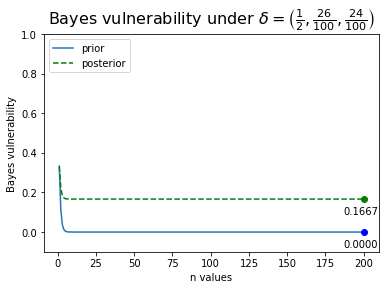

In [54]:
dfuni = graph_bayes_prior_post(200, 3, [1/3, 1/3, 1/3])

In [55]:
dfuni

,prior,posterior
0,3.3333333333e-01,0.3333333333
1,1.1111111111e-01,0.2222222222
2,3.7037037037e-02,0.1851851852
3,1.2345679012e-02,0.1728395062
4,4.1152263374e-03,0.1687242798
5,1.3717421125e-03,0.1673525377
6,4.5724737083e-04,0.1668952904
7,1.5241579028e-04,0.1667428746
8,5.0805263425e-05,0.1666920693
9,1.6935087808e-05,0.1666751342


In [36]:
n = 10
k = 3
probs = [1/2, 1/3, 1/6]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  0.0009765625
The posterior bayes vuln:  0.5100027327674895


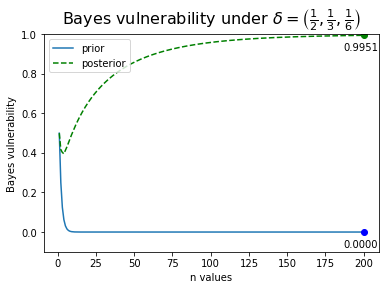

In [39]:
graph_bayes_prior_post(200, 3, [1/2, 1/3, 1/6])

In [43]:
n = 200
k = 3
probs = [1/2, 1/4, 1/4]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  6.223015277861142e-61
The posterior bayes vuln:  0.4999859734203035


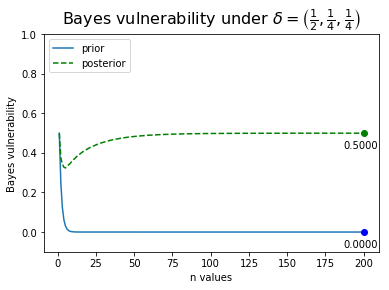

In [44]:
graph_bayes_prior_post(200, 3, [1/2, 1/4, 1/4])

In [45]:
n = 200
k = 3
probs = [1/2, .26, .24]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  6.223015277861142e-61
The posterior bayes vuln:  0.6553398219376529


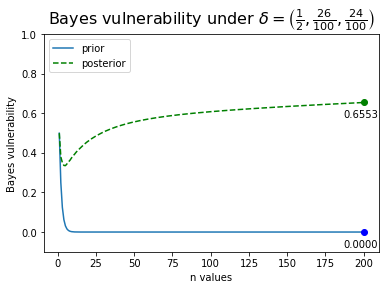

In [48]:
graph_bayes_prior_post(200, 3, [1/2, .26, .24])

In [34]:
n = 200
k = 4
probs = [1/4, 1/4, 1/4, 1/4]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  3.8725919148493183e-121
The posterior bayes vuln:  0.04166666666666664


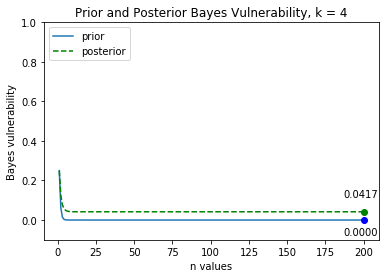

In [27]:
graph_bayes_prior_post(200, 4, [1/4, 1/4, 1/4, 1/4])

### Graph Under Uniform Prior

In [23]:
uni_post_bayes_vs = []
uni_prior_bayes_vs = []
for i in range(range_max):
    uni_post_bayes_vs.append(uni_post_bayes_vuln(i+1, k))
    uni_prior_bayes_vs.append(prior_bayes_vuln(i+1, uni_probs))
uni_bayes_vuln_df = pd.DataFrame(
    {'prior':uni_prior_bayes_vs,
     'posterior':uni_post_bayes_vs
    }
)
uni_bayes_vuln_df.head()

,prior,posterior
0,0.333333,1/3
1,0.111111,2/9
2,0.037037,5/27
3,0.012346,14/81
4,0.004115,41/243


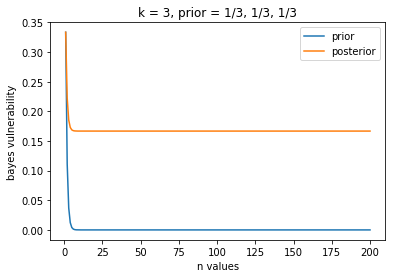

In [24]:
x = [i+1 for i in range(range_max)]

plt.plot(x, 'prior', data=uni_bayes_vuln_df, marker='', label="prior")
plt.plot(x, 'posterior', data=uni_bayes_vuln_df, marker='', label="posterior")
plt.xlabel('n values')
plt.ylabel('bayes vulnerability')

plt.title('k = 3, prior = 1/3, 1/3, 1/3')
plt.legend()
plt.show()